# Final Project

In [119]:
import matplotlib.pyplot as plt
import os, csv, shutil
from collections import defaultdict, namedtuple
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from PIL import Image
from skimage import io, transform
import numpy as np
import time
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import pickle

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   :  12}

matplotlib.rc('font', **font)

In [120]:
class GtsrbDataset(Dataset):
    """GTSRB Dataset"""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annos = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annos)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = io.imread(os.path.join(self.root_dir, self.annos.Path[idx]))
        
#         bbox = np.array([self.annos['Roi.X1'][idx], self.annos['Roi.Y1'][idx],
#                          self.annos['Roi.X2'][idx], self.annos['Roi.Y2'][idx]])        
#         sample = {'image': image, 'bbox': bbox, 'label':self.annos['ClassId'][idx]}
        sample = {'image': image, 'label':self.annos['ClassId'][idx]}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
#         landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        assert new_h <= h
        assert new_w <= w
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

#         landmarks = landmarks - [left, top]

        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(np.array([label]))}

In [4]:
base_dir = os.path.join('data', 'GTSRB')
train_csv = os.path.join(base_dir, 'Train.csv')

Gtsrb_train_dataset = GtsrbDataset(train_csv, base_dir,
                                   transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(244),
                                               ToTensor()]))

pct_val = 0.1
n_val = int(pct_val*len(Gtsrb_train_dataset))
train_set, val_set = torch.utils.data.random_split(Gtsrb_train_dataset, [len(Gtsrb_train_dataset)-n_val, n_val])
train_loader = DataLoader(train_set, batch_size=4,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=4,
                          shuffle=True, num_workers=0)

0 torch.Size([4, 3, 244, 244]) tensor([[[10, 23,  2,  2]]])


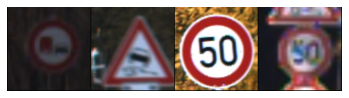

1 torch.Size([4, 3, 244, 244]) tensor([[[12, 11, 30,  1]]])


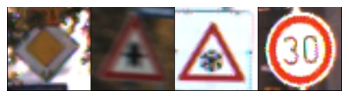

2 torch.Size([4, 3, 244, 244]) tensor([[[28, 31, 30, 38]]])


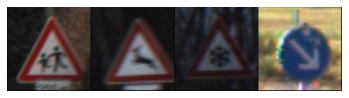

3 torch.Size([4, 3, 244, 244]) tensor([[[12, 11, 16, 33]]])


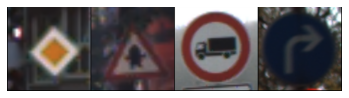

In [5]:
# Helper function to show a batch
def show_image_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'][:,None].T)

    # observe 4th batch and stop.
    plt.figure()
    show_image_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if i_batch == 3:
        break

### Explore Training Dataset

43 unique classes


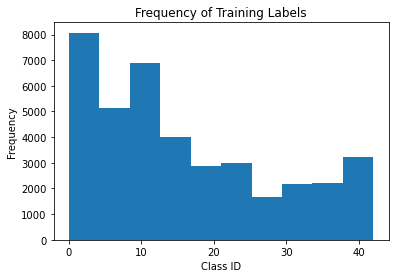

In [6]:
nunique = len(np.unique(Gtsrb_train_dataset.annos.ClassId))
print(f'{nunique} unique classes')

plt.hist(Gtsrb_train_dataset.annos.ClassId)
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Frequency of Training Labels')
plt.show()

### Fine-Tune Network Outputs

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, nunique)
# resnet101 = models.resnet101(pretrained=True)
input_size = 244

In [9]:
# Number of classes in the dataset
num_classes = nunique
batch_size = 256
num_epochs = 5
feature_extract = True

In [10]:
pct_val = 0.1
n_val = int(pct_val*len(Gtsrb_train_dataset))
train_set, val_set = torch.utils.data.random_split(Gtsrb_train_dataset, [len(Gtsrb_train_dataset)-n_val, n_val])
train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size,
                          shuffle=True, num_workers=0)
dataloaders_dict = {'train':train_loader, 'val':val_loader}

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in tqdm(dataloaders[phase]):
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)[:,0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                # Save the models as we go
                torch.save(model.state_dict(), 'resnet18_%i.pth'%epoch)
                print('model saved!')
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                ibest = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print(f'Best index: {ibest}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def get_optimizer(model_ft, print_params):
    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                if print_params:
                    print("\t",name)
        print(len(params_to_update))
    else:
        icount = 0
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                if print_params:
                    print("\t",name)
                icount += 1
        print(icount)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)    
    return optimizer_ft


def run_model(model_ft, dataloaders_dict, num_epochs, print_params=False, is_inception=False):
    optimizer_ft = get_optimizer(model_ft, print_params)
    criterion = nn.CrossEntropyLoss()
    model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion,
                                 optimizer_ft, num_epochs=num_epochs, is_inception=is_inception)
    return model_ft, train_hist, val_hist

In [13]:
resnet18, train_hist, val_hist = run_model(resnet18, dataloaders_dict, num_epochs)

Params to learn:
62
Epoch 0/4
----------


100%|█████████████████████████████████████████████████████████| 138/138 [07:53<00:00,  3.43s/it]


train Loss: 2.2603 Acc: 0.4608
model saved!


100%|███████████████████████████████████████████████████████████| 16/16 [00:47<00:00,  2.95s/it]


val Loss: 1.1740 Acc: 0.7375

Epoch 1/4
----------


100%|█████████████████████████████████████████████████████████| 138/138 [07:52<00:00,  3.42s/it]


train Loss: 0.7677 Acc: 0.8412
model saved!


100%|███████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.92s/it]


val Loss: 0.4611 Acc: 0.9140

Epoch 2/4
----------


100%|█████████████████████████████████████████████████████████| 138/138 [07:51<00:00,  3.42s/it]


train Loss: 0.3272 Acc: 0.9530
model saved!


100%|███████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.91s/it]


val Loss: 0.2287 Acc: 0.9704

Epoch 3/4
----------


100%|█████████████████████████████████████████████████████████| 138/138 [07:48<00:00,  3.39s/it]


train Loss: 0.1725 Acc: 0.9801
model saved!


100%|███████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.91s/it]


val Loss: 0.1383 Acc: 0.9821

Epoch 4/4
----------


100%|█████████████████████████████████████████████████████████| 138/138 [07:48<00:00,  3.40s/it]


train Loss: 0.1078 Acc: 0.9886
model saved!


100%|███████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.93s/it]

val Loss: 0.0967 Acc: 0.9880

Training complete in 43m 10s
Best val Acc: 0.988010
Best index: 4


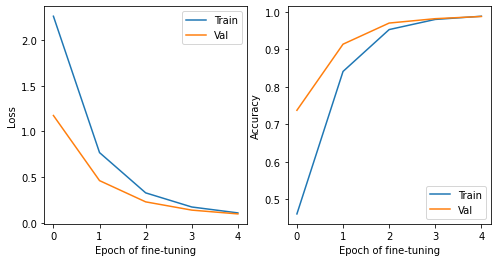

In [49]:
# Make plot
train_loss_acc = [(2.2603, 0.4608), (0.7677, 0.8412), (0.3272, 0.9530), (0.1725, 0.9801), (0.1078, 0.9886)]
val_loss_acc = [(1.1740, 0.7375), (0.4611, 0.9140), (0.2287, 0.9704), (0.1383, 0.9821), (0.0967, 0.9880)]

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot([tla[0] for tla in train_loss_acc], label='Train')
axs[0].plot([vla[0] for vla in val_loss_acc], label='Val')
axs[0].set_xlabel('Epoch of fine-tuning')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot([tla[1] for tla in train_loss_acc], label='Train')
axs[1].plot([vla[1] for vla in val_loss_acc], label='Val')
axs[1].set_xlabel('Epoch of fine-tuning')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

## Try Cleverhans On An Example

In [6]:
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2

In [7]:
nunique = len(np.unique(Gtsrb_train_dataset.annos.ClassId))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet18_att = models.resnet18()
resnet18_att.fc = nn.Linear(resnet18_att.fc.in_features, nunique)
resnet18_att.load_state_dict(torch.load('resnet18_4.pth'))
resnet18_att.to(device)
resnet18_att.eval()
pass

In [8]:
def inference(val_set, idx):
    x_val = val_set[idx]
    inputs = torch.unsqueeze(x_val['image'].to(device).float(), 0)
    labels = x_val['label'].to(device)
    outputs = resnet18_att(inputs)
    _, preds = torch.max(outputs, 1)
    return preds, outputs

In [9]:
_, outputs = inference(val_set, 0)

In [12]:
idx = 0
orig_x = torch.unsqueeze(val_set[idx]['image'].float().to(device), 0)
orig_label = val_set[idx]['label'].to(device)

# PGD
adv_x_pgd = projected_gradient_descent(
    resnet18_att,
    orig_x,
    eps=0.3,
    eps_iter=0.01,
    nb_iter=40,
    norm=np.inf,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    rand_init=True,
    rand_minmax=None,
    sanity_checks=True)

# FGM
adv_x_fgm = fast_gradient_method(resnet18_att,
                             orig_x,
                             eps=0.3,
                             norm=np.inf,
                             clip_min=None,
                             clip_max=None,
                             y=None,
                             targeted=False,
                             sanity_checks=True)

# CW
adv_x_cw = carlini_wagner_l2(resnet18_att,
                             orig_x,
                             nunique,
                             max_iterations=100)

In [13]:
# Check results
output_orig = resnet18_att(orig_x)
_, pred_orig = torch.max(output_orig, 1)

output_adv_pgd = resnet18_att(adv_x_pgd)
_, pred_adv_pgd = torch.max(output_adv_pgd, 1)

output_adv_fgm = resnet18_att(adv_x_fgm)
_, pred_adv_fgm = torch.max(output_adv_fgm, 1)

output_adv_cw = resnet18_att(adv_x_cw)
_, pred_adv_cw = torch.max(output_adv_cw, 1)


print(f'Truth output class: {orig_label}')
print(f'Original output class: {pred_orig}')
print(f'Adversarial output class, PGD: {pred_adv_pgd}')
print(f'Adversarial output class, FGM: {pred_adv_fgm}')
print(f'Adversarial output class, CW: {pred_adv_cw}')

Truth output class: tensor([33], device='cuda:0')
Original output class: tensor([33], device='cuda:0')
Adversarial output class, PGD: tensor([12], device='cuda:0')
Adversarial output class, FGM: tensor([12], device='cuda:0')
Adversarial output class, CW: tensor([34], device='cuda:0')


#### Evaluation

In [18]:
np.random.seed(100)

nimages = 100
eps_range = np.logspace(-3, 0, 10)
methods = ['cw', 'fgm']
norms = [2, 'inf']
targeteds = [True, False]

In [38]:
def run_attack_for_param(p):
    idx_x, eps, method, norm, targeted = int(p[0]), float(p[1]), p[2], p[3], p[4]=='True'
    norm = np.inf if norm == 'inf' else int(float(norm))
    
    im_x = torch.unsqueeze(val_set[idx_x]['image'].float(), 0).to(device)
    orig_label = val_set[idx_x]['label'].to(device)
    y_targ = val_set[targ_dict[idx_x]]['label'].to(device) if targeted else None
    y_targ_print = y_targ.cpu().numpy()[0] if y_targ else y_targ
    
    if print_prog:
        print(f'Running {method} on idx {idx_x}, label {orig_label.cpu().numpy()[0]} with '+\
              f'{y_targ_print} target and {eps} epsilon at {norm} norm')
        
    # Run original
    output_orig = resnet18_att(im_x)
    _, pred_orig = torch.max(output_orig, 1)
    
    # Run attack
    if method == 'pgd':
        raise
        im_x = projected_gradient_descent(
            resnet18_att,
            im_x,
            eps=eps,
            eps_iter=eps/5,
            nb_iter=40,
            norm=norm,
            clip_min=None,
            clip_max=None,
            y=y_targ,
            targeted=targeted,
            rand_init=True,
            rand_minmax=None,
            sanity_checks=False).detach()
    elif method == 'cw':
        if norm != 2:
            return None
        im_x = carlini_wagner_l2(
            resnet18_att,
            im_x,
            nunique,
            y=y_targ,
            targeted=targeted,
            lr=eps/10,
            max_iterations=50).detach()
    elif method == 'fgm':
        im_x = fast_gradient_method(
            resnet18_att,
            im_x,
            eps=eps,
            norm=norm,
            clip_min=None,
            clip_max=None,
            y=y_targ,
            targeted=targeted,
            sanity_checks=True).detach()
    else:
        raise NotImplemented
        
    # Run network 
    with torch.no_grad():
        output_adv = resnet18_att(im_x)
        _, pred_adv = torch.max(output_adv, 1)
        
    # Save results
    new_res = {'idx_x':idx_x, 'label':orig_label.cpu().numpy()[0], 'label_pred':pred_orig.cpu().numpy()[0], 
               'label_pred_adv':pred_adv.cpu().numpy()[0], 'eps':eps, 'method':method, 'norm':norm, 
               'y_targ':y_targ_print}
    
    # Clear memory?
    torch.cuda.empty_cache()

    return new_res

In [ ]:
# Cases: 
"""
sample 1000 images
1 for each eps
use PGD and FGSM
use targeted and untargeted attacks
"""
results = []
print_prog = False

# Params array
idx_x = np.random.choice(list(range(len(val_set))), size=(nimages,), replace=False)
idx_targ = np.random.choice(list(range(len(val_set))), size=(nimages,), replace=False)
targ_dict = {x:t for x, t in zip(idx_x, idx_targ)}

g = np.meshgrid(idx_x, eps_range, methods, norms, targeteds)
params = np.vstack(map(np.ravel, g))

# Loop and run, saving results
icount = 0
ncount_save = 1000
for p in tqdm(params.T):
    icount += 1
    if icount % ncount_save == 0:
        pickle.dump(results, open('temp_results.p', 'wb'))
        print('Saved temp')
    new_res = run_attack_for_param(p)
    if new_res is None:
        continue
    results.append(new_res)
    
results_df = pd.DataFrame(results)
pickle.dump(results_df, open('results_large_scale.p', 'wb'))

/tmp/ipykernel_13917/2553131608.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  params = np.vstack(map(np.ravel, g))
 12%|████████▏                                                         | 999/8000 [10:15<49:51,  2.34it/s]

Saved temp


 25%|████████████████▏                                                | 1999/8000 [20:30<42:12,  2.37it/s]

Saved temp


 37%|████████████████████████▎                                        | 2999/8000 [30:41<33:58,  2.45it/s]

Saved temp


 50%|████████████████████████████████▍                                | 3999/8000 [40:52<26:32,  2.51it/s]

Saved temp


 51%|█████████████████████████████████▏                               | 4088/8000 [41:45<26:29,  2.46it/s]

In [27]:
# Explore results
# results_df = pickle.load(open('results_large_scale.p', 'rb'))

#### Plot Results

In [77]:
import seaborn as sns
results_df.head()

,idx_x,label,label_pred,label_pred_adv,eps,method,norm,y_targ
0,417,35,35,39,0.001,cw,2.0,39
1,417,35,35,36,0.001,cw,2.0,None
2,417,35,35,35,0.001,fgm,2.0,39
3,417,35,35,35,0.001,fgm,2.0,None
4,417,35,35,35,0.001,fgm,inf,39


In [86]:
idx_targ = ~results_df['y_targ'].isnull()
successful = results_df['label_pred'] != results_df['label_pred_adv']
successful[idx_targ] = (results_df['label_pred_adv'] == results_df['y_targ'])[idx_targ]

In [166]:
def success_marginal(param_tup_list):
    idx_where = pd.Series([True]*len(results_df))
    for param_tup in param_tup_list:
        if callable(param_tup[1]):
            idx_where = idx_where & (pd.Series([param_tup[1](y) for y in results_df[param_tup[0]]]))
        else:
            idx_where = idx_where & (results_df[param_tup[0]] == param_tup[1])
    success_sub = successful[idx_where]
    print(f'Success of filtered results -- {param_tup_list}:\n ---{sum(success_sub) / len(success_sub)}')

In [200]:
success_marginal([('method', 'cw')])
success_marginal([('method', 'fgm')])
success_marginal([('method', 'fgm'), ('norm', 2)])
success_marginal([('method', 'fgm'), ('norm', np.inf)])
success_marginal([('method', 'fgm'), ('norm', np.inf)])
success_marginal([('method', 'fgm'), ('norm', 2), ('y_targ', lambda x: pd.isnull(x))])
success_marginal([('method', 'fgm'), ('norm', np.inf), ('y_targ', lambda x: ~pd.isnull(x))])

Success of filtered results -- [('method', 'cw')]:
 ---1.0
Success of filtered results -- [('method', 'fgm')]:
 ---0.202
Success of filtered results -- [('method', 'fgm'), ('norm', 2)]:
 ---0.0835
Success of filtered results -- [('method', 'fgm'), ('norm', inf)]:
 ---0.3205
Success of filtered results -- [('method', 'fgm'), ('norm', inf)]:
 ---0.3205
Success of filtered results -- [('method', 'fgm'), ('norm', 2), ('y_targ', <function <lambda> at 0x7f39892f1670>)]:
 ---0.1
Success of filtered results -- [('method', 'fgm'), ('norm', inf), ('y_targ', <function <lambda> at 0x7f39892f1670>)]:
 ---0.072


In [125]:
idx_cw = results_df.method == 'cw'
idx_fgm = results_df.method == 'fgm'

def success_by_param(param_key, method):
    if method == 'cw':
        idx_method = idx_cw
    else:
        idx_method = idx_fgm
        
    results_method = results_df[idx_method]
    successful_method = successful[idx_method]
    
    vals = results_method[param_key].unique()
    res = []
    for v in vals:
        idx_v = results_method[param_key] == v
        n_succ = sum(successful_method[idx_v])
        n_tot = sum(idx_v)
        res.append(n_succ / n_tot)
    
    plt.plot(vals, res, linewidth=3, label=method)
    plt.xlabel(param_key)
    plt.ylabel('Attack Success Rate Marginal')
    plt.legend()
    plt.show()

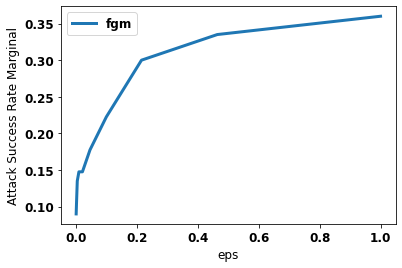

In [128]:
success_by_param('eps', 'fgm')

#### Get Performance Timing

In [176]:
n_test = 50

In [178]:
%%time
for idx in tqdm(range(n_test)):
    orig_x = torch.unsqueeze(val_set[idx]['image'].float().to(device), 0)
    orig_label = val_set[idx]['label'].to(device)
    adv_x_fgm = fast_gradient_method(resnet18_att,
                                 orig_x,
                                 eps=0.3,
                                 norm=np.inf,
                                 clip_min=None,
                                 clip_max=None,
                                 y=None,
                                 targeted=False,
                                 sanity_checks=True)

100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.27it/s]

CPU times: user 34.7 s, sys: 1.05 s, total: 35.7 s
Wall time: 2.25 s


In [181]:
%%time
for idx in tqdm(range(n_test)):
    orig_x = torch.unsqueeze(val_set[idx]['image'].float().to(device), 0)
    orig_label = val_set[idx]['label'].to(device)
    adv_x_cw = carlini_wagner_l2(resnet18_att,
                                 orig_x,
                                 nunique,
                                 max_iterations=50)

100%|█████████████████████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.28s/it]

CPU times: user 4min 1s, sys: 4.09 s, total: 4min 6s
Wall time: 1min 54s


In [194]:
niters = range(1, 6, 1)
n_test = 50
succ_list = []
for niter in niters:
    print(f'{int(niter)} iterations')
    n_succ = 0
    for idx in tqdm(range(n_test)):
        orig_x = torch.unsqueeze(val_set[idx]['image'].float().to(device), 0)
        orig_label = val_set[idx]['label'].to(device)
        with torch.no_grad():
            output_orig = resnet18_att(orig_x)
            _, pred_orig = torch.max(output_orig, 1)
        adv_x_cw = carlini_wagner_l2(resnet18_att,
                                     orig_x,
                                     nunique,
                                     initial_const=1e-4,
                                     max_iterations=int(niter))
        with torch.no_grad():
            output_adv = resnet18_att(adv_x_cw)
            _, pred_adv = torch.max(output_adv, 1)
        if pred_adv != pred_orig:
            n_succ += 1
    print(f'{n_succ/n_test} pct success\n\n')
    succ_list.append(n_succ)

1 iterations


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.46it/s]


0.2 pct success


2 iterations


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.81it/s]


0.74 pct success


3 iterations


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


0.96 pct success


4 iterations


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


0.98 pct success


5 iterations


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.56it/s]

1.0 pct success




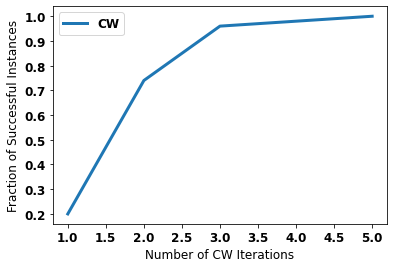

In [198]:
plt.plot(niters, [s/n_test for s in succ_list], label='CW', linewidth=3)
plt.xlabel('Number of CW Iterations')
plt.ylabel('Fraction of Successful Instances')
plt.legend()
plt.show()